# Homework 2 - Vertical FL and Generative Modeling

Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, the latter creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 

# Instructions

Submit your assignment in ILIAS as only the Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.


## Exercise 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_2b/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **3** random feature permutations and plot the training loss. Report whether/how shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 3 feature permutations with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ Describe what impact (if any) the permutations have on the loss and explain the observed pattern.

In [1]:
import random

import numpy as np
import torch

from matplotlib import pyplot as plt
from tqdm import tqdm 
import vfl

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
from components import preprocessing, partitions
from numpy import random as npr

features = preprocessing.feature_names

generator = npr.default_rng(seed=42)
for _ in range(3):
    permuted_features_idx = npr.permutation(len(features))
    permuted_features = [features[idx] for idx in permuted_features_idx]

    print(partitions.partition_elements_uniformly(permuted_features, 4))
    

[['restecg', 'ca', 'chol'], ['slope', 'cp', 'exang'], ['sex', 'thalach', 'oldpeak'], ['trestbps', 'age', 'fbs', 'thal']]
[['fbs', 'cp', 'trestbps'], ['chol', 'ca', 'age'], ['oldpeak', 'thal', 'thalach'], ['restecg', 'sex', 'slope', 'exang']]
[['slope', 'sex', 'restecg'], ['thalach', 'cp', 'thal'], ['fbs', 'ca', 'age'], ['trestbps', 'chol', 'oldpeak', 'exang']]


In [3]:
client_feature_name_mapping_variants = {
    "default": [
        ["age", "sex", "cp"],
        ["trestbps", "chol", "fbs"],
        ["restecg", "thalach", "exang"],
        ["oldpeak", "slope", "ca", "thal"],
    ],
    "columns permuted": [
        ["cp", "age", "sex"],
        ["fbs", "trestbps", "chol"],
        ["exang", "restecg", "thalach"],
        ["thal", "oldpeak", "slope", "ca"],
    ],
    "dissimilar": [
        ["age", "trestbps", "thalach"],
        ["sex", "chol", "exang"],
        ["restecg", "thal", "slope"],
        ["oldpeak", "ca", "fbs", "cp"],
    ],
    "random #1": [
        ["oldpeak", "sex", "fbs"],
        ["age", "slope", "thalach"],
        ["chol", "thal", "exang"],
        ["trestbps", "restecg", "ca", "cp"],
    ],
    "random #2": [
        ["age", "fbs", "cp"],
        ["restecg", "thal", "thalach"],
        ["chol", "slope", "ca"],
        ["oldpeak", "sex", "exang", "trestbps"],
    ],
    "random #3": [
        ["exang", "oldpeak", "fbs"],
        ["chol", "thal", "slope"],
        ["sex", "trestbps", "age"],
        ["cp", "thalach", "ca", "restecg"],
    ],
}

training_statistics, test_statistics = zip(
    *[
        vfl.run(client_feature_name_mapping=it)
        for it in tqdm(client_feature_name_mapping_variants.values(), "variant", leave=False)
    ]
)

training_statistics = list(training_statistics)
test_statistics = list(test_statistics)

variant:   0%|          | 0/6 [00:00<?, ?it/s]

(0.85, 1.0)

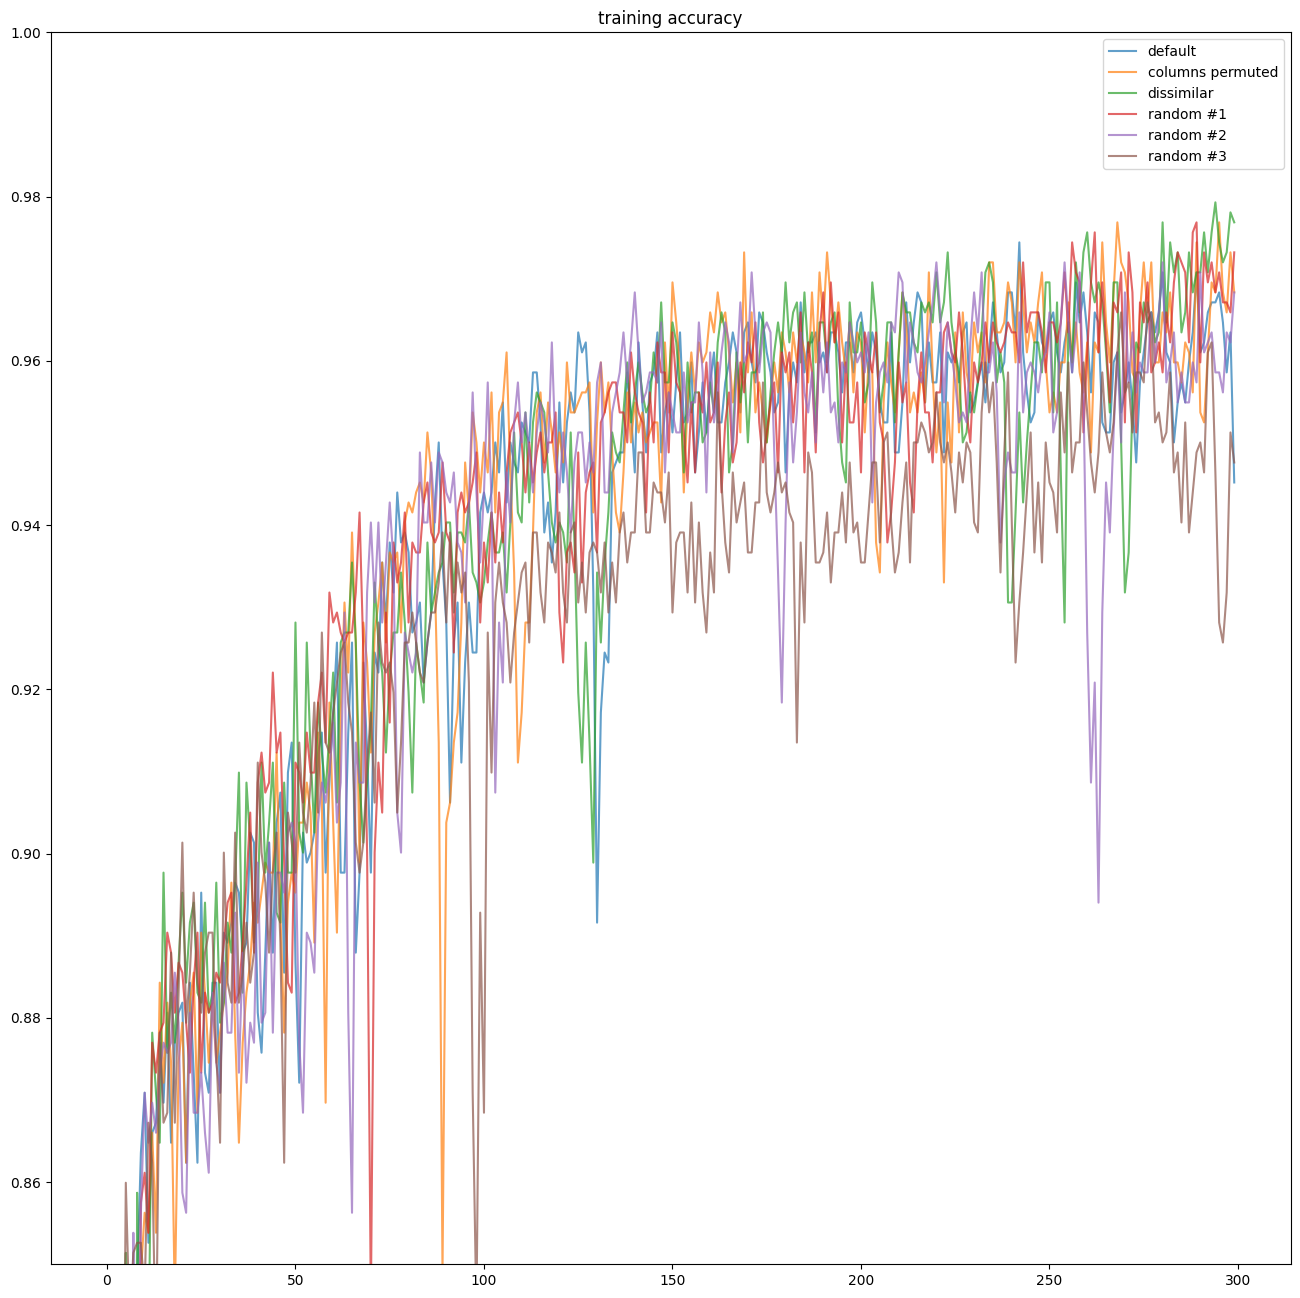

In [4]:
plt.figure(figsize=(16, 16))
plt.title("training accuracy")
for statistics, variant_name in zip(training_statistics, client_feature_name_mapping_variants.keys()):
    plt.plot(statistics.mean_epoch_accuracies, label=variant_name, alpha=0.7)
plt.legend()
plt.ylim(0.85, 1)

(0.00932402466020834, 0.3)

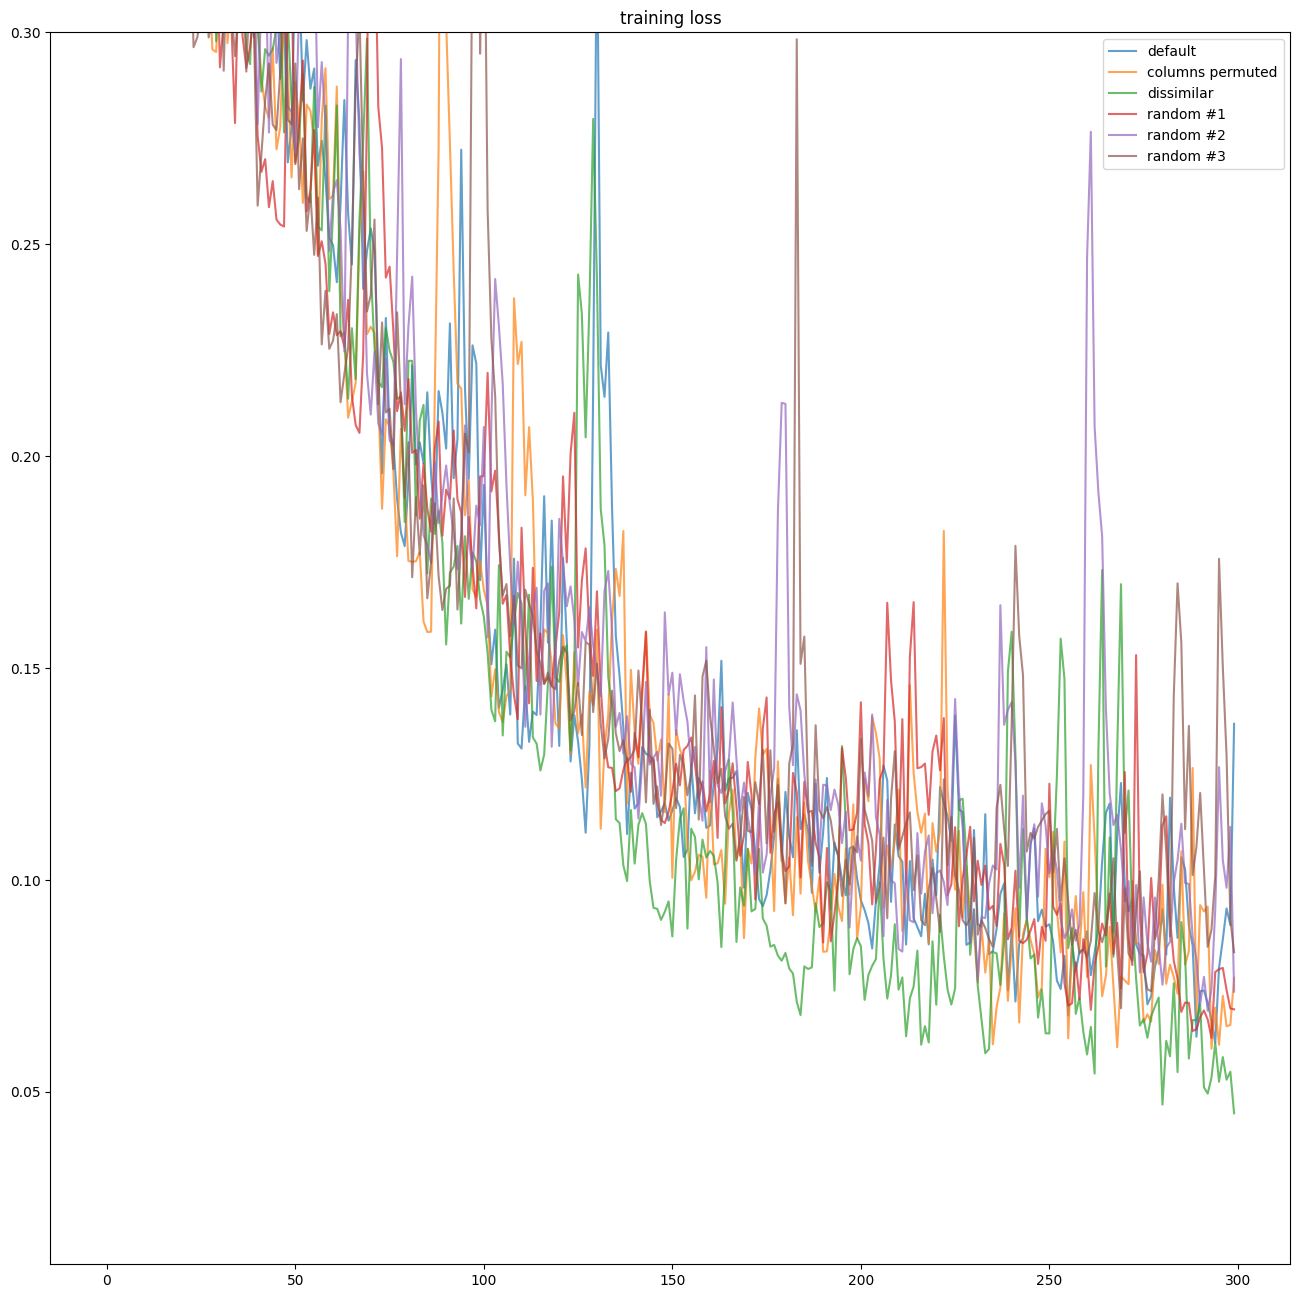

In [5]:
plt.figure(figsize=(16, 16))
plt.title("training loss")
for statistics, variant_name in zip(training_statistics, client_feature_name_mapping_variants.keys()):
    plt.plot(statistics.mean_epoch_losses, label=variant_name, alpha=0.7)
plt.legend()
plt.ylim(None, .3)

(0.85, 1.0)

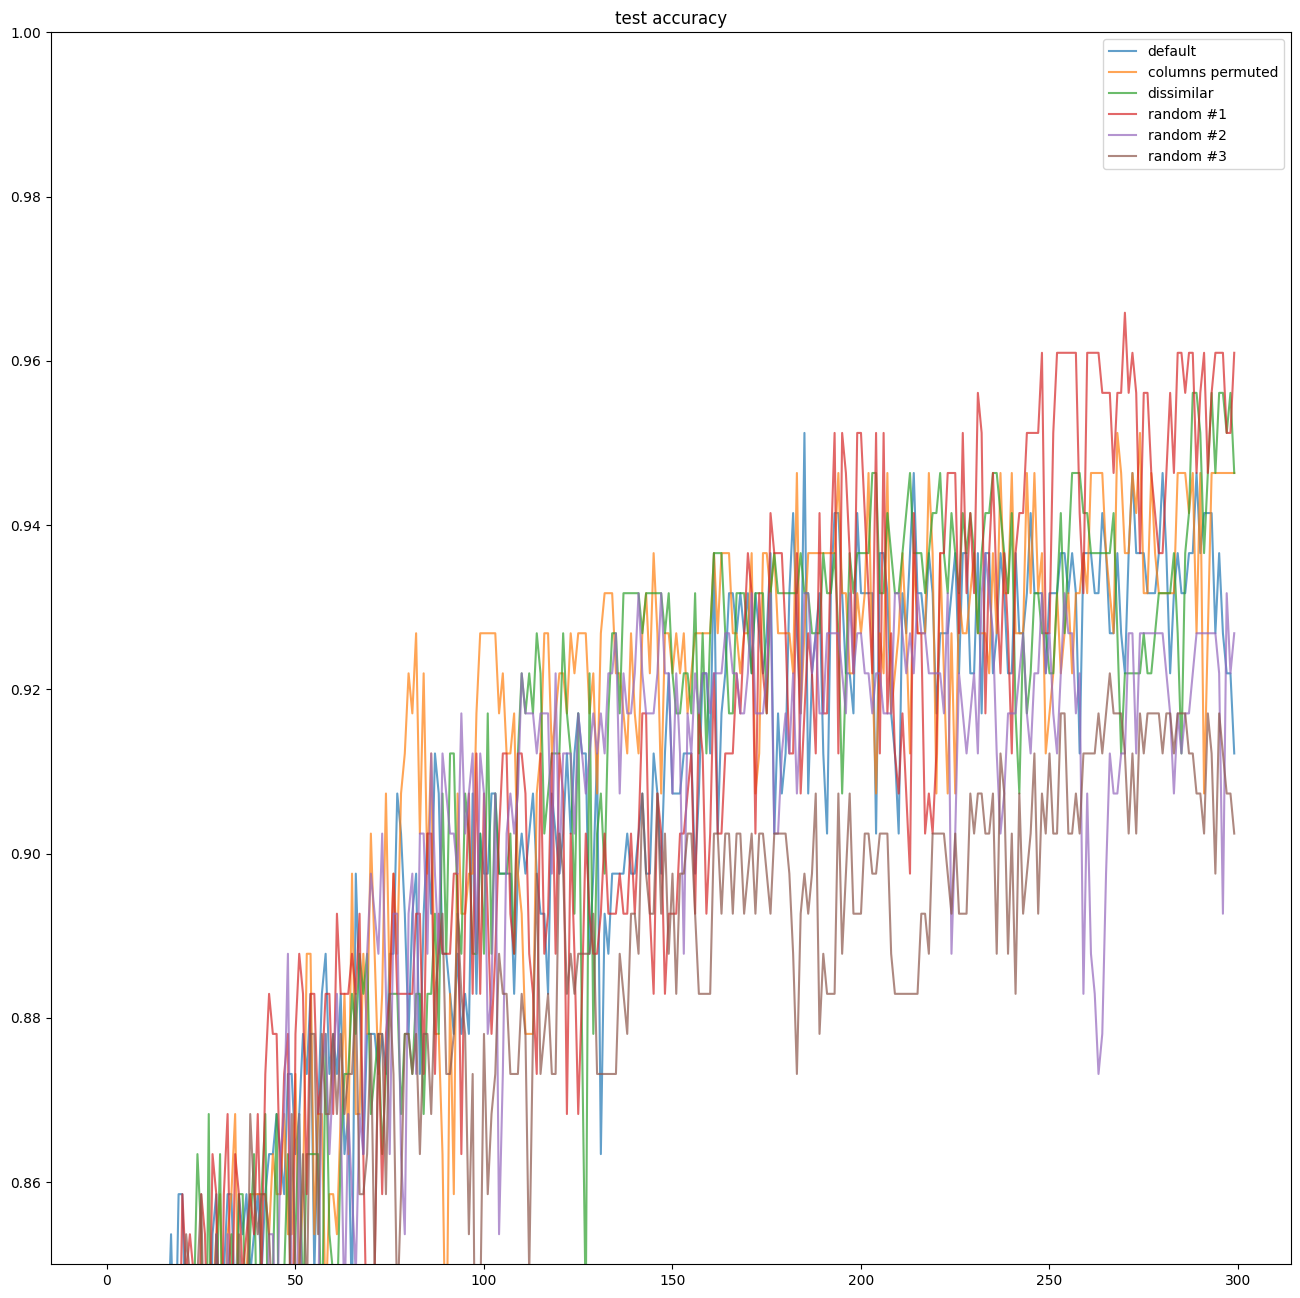

In [6]:
plt.figure(figsize=(16, 16))
plt.title("test accuracy")
for statistics, variant_name in zip(test_statistics, client_feature_name_mapping_variants.keys()):
    plt.plot(statistics.mean_epoch_accuracies, label=variant_name, alpha=0.7)
plt.legend()
plt.ylim(0.85, 1)

To better understand how the permutation of the features impacts performance, we consider the following four types of permutations:

1. no permutation (features are left in order in which they appear in dataset) (`default`)
2. intra-client permutation wrt. 1 (features are permuted without changing the assignment of features to clients) (`columns permuted`)
3. inter-client permutation wrt. 1 (features are permuted such that the assignment of features significantly changes) (`dissimilar`)
4. random permutations

First, we observe that permuting the features within a client (i.e., without affecting the assignment of features to clients) only barely affects performance.
It is noticeable that the training of the permuted variant is significantly smoother though.
Those effects can be explained by the used model initialization (identical for all runs) and are probably not inherent to the permutation.

The same can be said about the considered inter-client permutation and the random permutations.
The overall trends match, and the resulting test performance only diverges by a few percentage points.
One noticeable exception is the third random permutation.
Its training loss, training accuracy, and especially test accuracy are noticeably worse, with test accuracy being off by around 5 percent.

Generally, we observe that the assignment of the features may have an impact on performance.
It is hard to generalize from those particular results as they only consider a single model initialization, which may already explain the observed effects on its own.
Also, it is fair to assume that the impact of different feature assignments strongly depends on the dataset.
Datasets in which only few features are relevant for the to-be-predicted target may be affected more significantly.
Similar effects can be expected in situations in which multiple features are only meaningful when portrayed together.

## Exercise 2: Scaling clients in VFL (5 points)

With the same template as above, experiment with how increasing the number of clients affects model performance. Explain the policy chosen for distributing features for different numbers of clients.

Scoring:
- _(1 point)_ Explain your scheme for partitioning the feature space under increasing number of clients.
- _(1 point)_ Implement the above explained partition mechanism for the requested client counts for the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

In [7]:
client_variants = [1, 2, 4, 6, 8, 13]

training_statistics, test_statistics = zip(
    *[
        vfl.run(clients=it)
        for it in tqdm(client_variants, "variant", leave=False)
    ]
)

training_statistics = list(training_statistics)
test_statistics = list(test_statistics)

(0.85, 1.0)

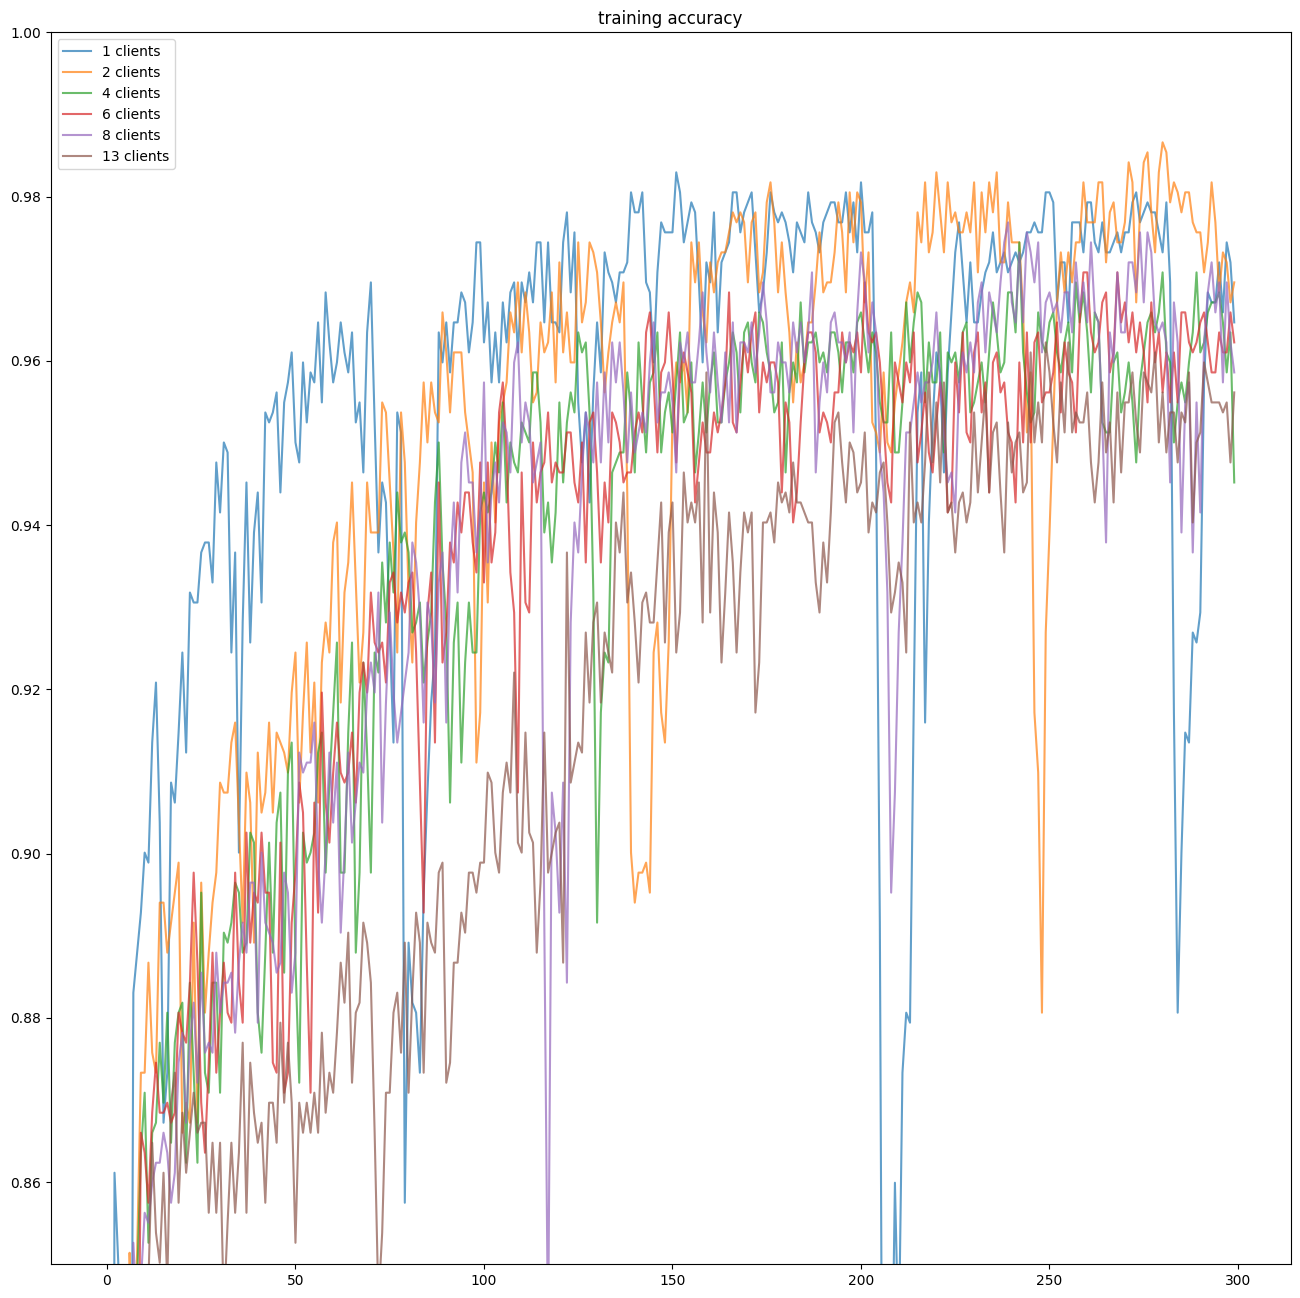

In [8]:
plt.figure(figsize=(16, 16))
plt.title("training accuracy")
for statistics, variant_name in zip(training_statistics, client_variants):
    plt.plot(statistics.mean_epoch_accuracies, label=f"{variant_name} clients", alpha=0.7)
plt.legend()
plt.ylim(0.85, 1)

(-0.009456515566965279, 0.3)

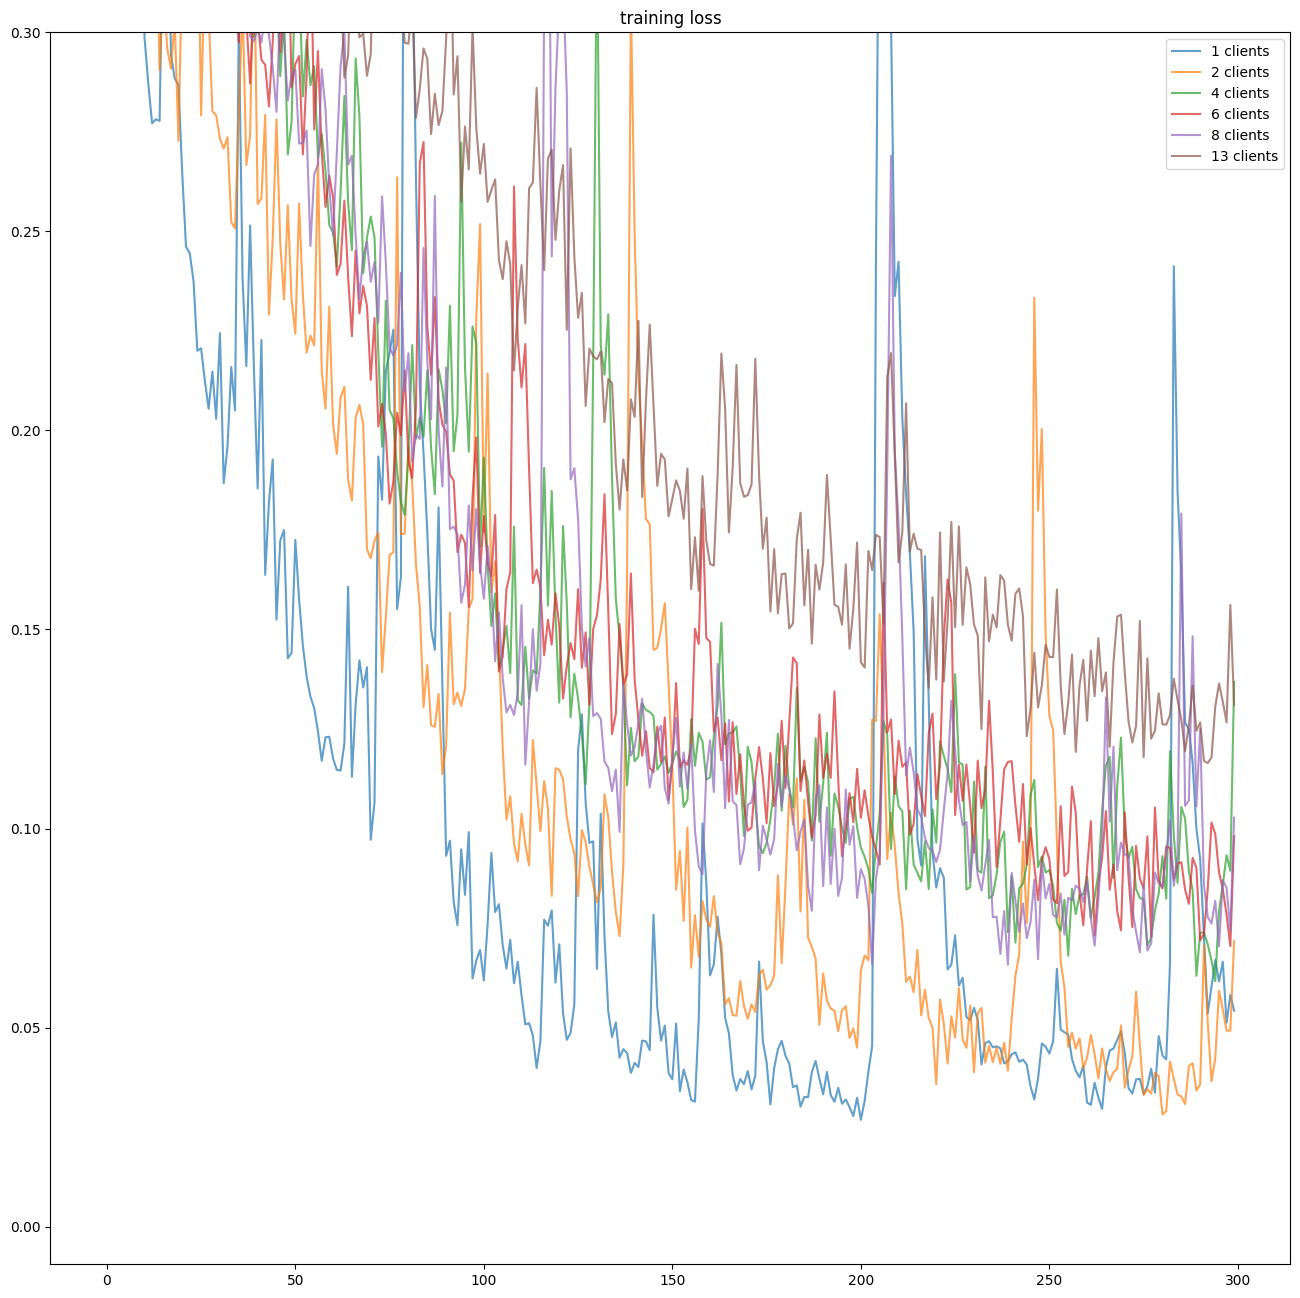

In [9]:
plt.figure(figsize=(16, 16))
plt.title("training loss")
for statistics, variant_name in zip(training_statistics, client_variants):
    plt.plot(statistics.mean_epoch_losses, label=f"{variant_name} clients", alpha=0.7)
plt.legend()
plt.ylim(None, .3)

(0.85, 1.0)

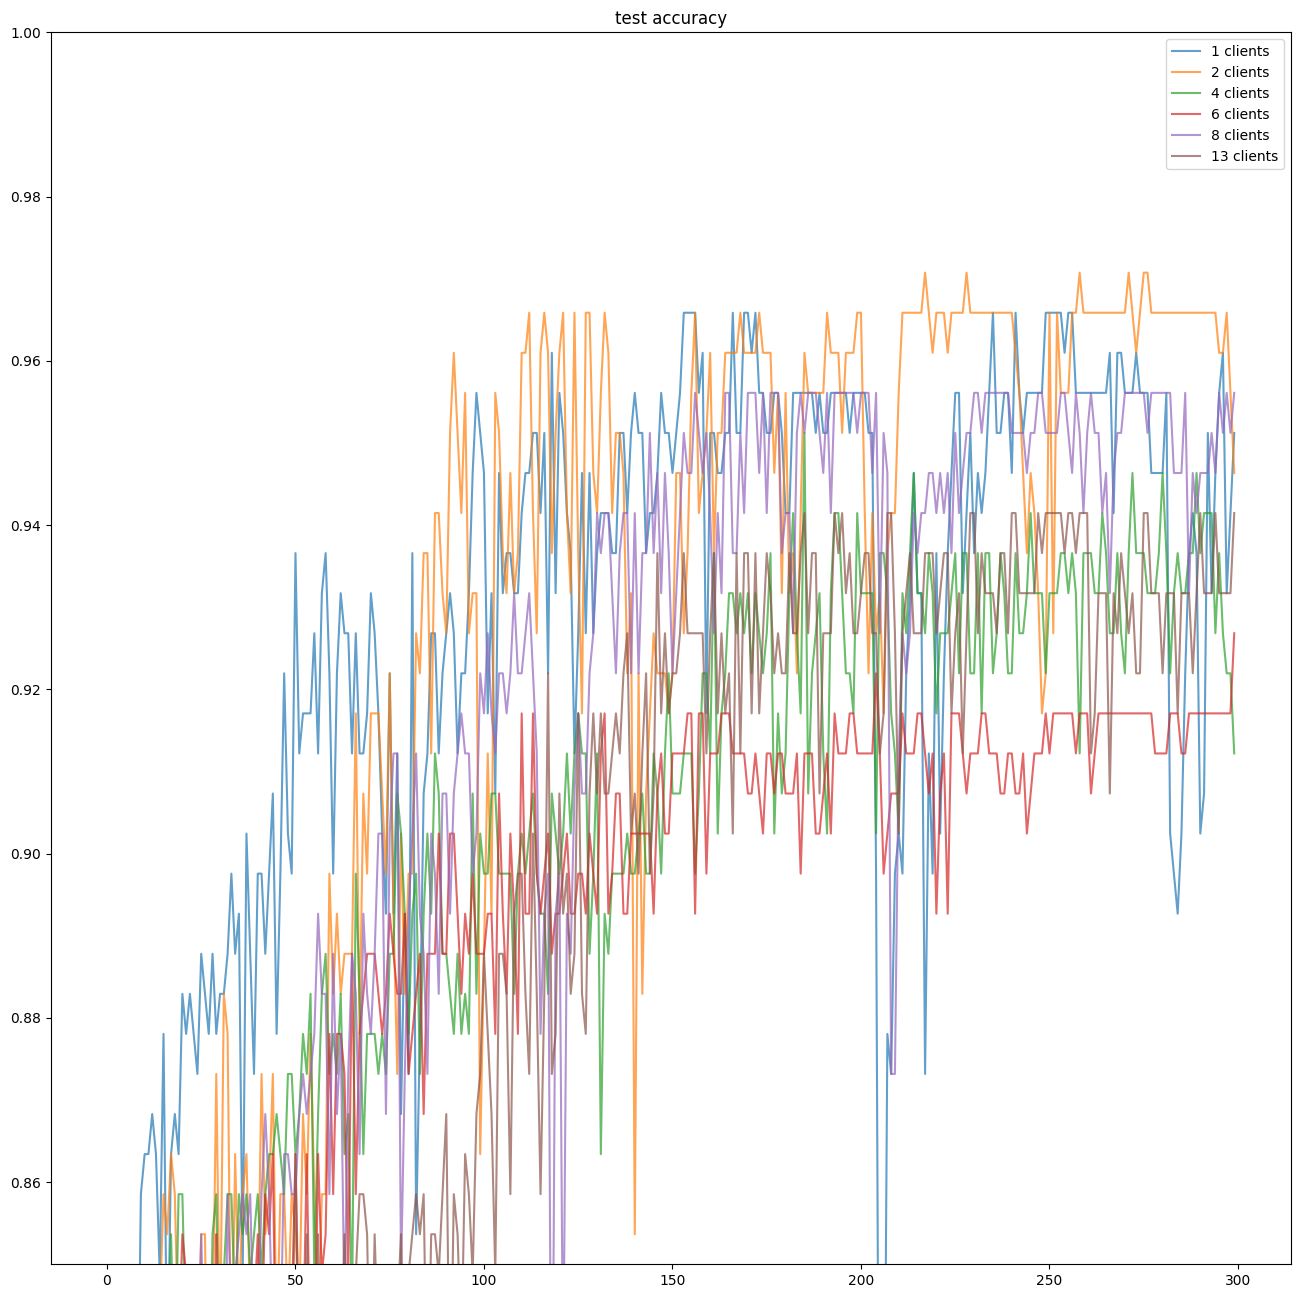

In [10]:
plt.figure(figsize=(16, 16))
plt.title("test accuracy")
for statistics, variant_name in zip(test_statistics, client_variants):
    plt.plot(statistics.mean_epoch_accuracies, label=f"{variant_name} clients", alpha=0.7)
plt.legend()
plt.ylim(0.85, 1)

### partitioning scheme

Features are partitioned evenly among all clients.
All clients are assigned exactly `feature_count // client_count` features, except for the last one which additionally obtains the remainder of `feature_count % client_count` features.

Features are assigned in traversal order.
Let $n_i$ be the number of features that client $i$ receives.
Then, client 1 receives the first $n_1$ features, client 2 the next $n_2$, and so on.

### observations

We observe that the number of clients significantly affects performance with regard to training loss, training accuracy, and test accuracy.
Clearly, performance deteriorates as the number of clients increases.
The spans between the best and the worst accuracy on the train and the test dataset are consistent.

In our assignment scheme, the fixed number of features are evenly distributed over all clients.
As the number of clients increases, the number of features per client decreases.
This limits the locally-available information, and makes it harder for clients to generalize over a larger number of features.
As clients struggle to generalize, their outputs becomes less useful too.
This makes it harder for the aggregator to compensate, even though the amount of globally-available information is the same over all experiments.

## Exercise 3: Bridging VFL and generative modeling (10 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. Combine VFL with variational autoencoders (VAEs) using the architecture described as follows. Each client uses a local encoder, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another local MLP (decoder) at each client. Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features.
- _(2 points)_ Define the encoder and decoder MLPs held by each client.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, including formulating the loss and printing it at every epoch.
- _(0.5 points)_ Consider, without implementing, an alternative scheme wherein the MLPs are first locally trained at the clients, followed by a separate training loop for the VAE at the server. How does this change what should be provided as input to the server?
- _(1.5 points)_ What are the pros and cons of the above mentioned alternative compared to the one implemented? Focus on the following aspects: privacy, communication costs, and performance.

### training client models locally

Training the client encoders and decoders separately from the aggregator model on the server raises the question against which targets the local models should be trained.
After all, those models need to produce some latent representation which can be learned by the aggregator, or have to decode some latent representation which is produced by the aggregator.
To ensure that those models work with meaningful latent representations, we could train them with a local autoencoder which only operates on the features that the client holds.

As for the server, it still needs some form of data for training.
If there's a reference dataset available, the autoencoder could be trained separately from the client models.
That is, once the clients have submitted their encoder and decoder models in a one-shot federated learning fashion, they are no longer part of the training loop.

If such a dataset is not available, client involvement is still required.
As within the original training scheme, clients would provide activations of their encoders (i.e., the latent representation) as well as relevant gradients of their decoders.
It is not necessary for the server to send gradients to the client encoders though, as we assume the client models to be static.
This ensures that clients do not have to disclose their training data to the server.

In the following section, we assume that the prior training scheme is used, as it comes closest to what one would call a "separate training loop".

### pros and cons of one-shot federated learning scheme

A one-shot federated learning scheme is advantageous in terms of communication cost but may be detrimental in terms of privacy and performance. 

The communication overhead of one-shot federated learning can generally be assumed to be lower than that of iterative training schemes.
In one-shot federated learning, every client transmits the parameters of its local model exactly once to the server.
In an iterative learning scheme, clients would have to send activations and gradients for every minibatch.
While those are smaller in size than the model parameters when considered in isolation, the data volume quickly adds up over multiple minibatches and epochs.
Also note that additional communication among the clients is required for identity alignment, as all clients need to agree on which records should be processed (in which order).
In a one-shot federated learning scheme, every client can train its local models without such alignment.

Note that one-shot federated learning does not require any client involvement during inference, whereas the implemented scheme clearly does.
That is, unless the clients also share their parameters with the server after training, which may raise privacy concerns.

In terms of performance, it seems reasonable to assume that a training scheme in which parts of the model are trained separately performs worse than one in which all parts are trained together.
In the present auto-encoder architecture, this is less of a concern, as every encoder-decoder pair must reproduce the examples they are presented with, regardless of how they came to be.
Still, it is noteworthy that the encoder-decoder pairs of the clients are not variational, i.e., they do not necessarily learn a representation with a specific distribution.
Some of those representations may be harder to reproduce by a variational auto-encoder (i.e., the model trained by the server) than others.
If the models were trained together, the variational auto-encoder controlled by the server could nudge the client-controlled auto-encoders to learn a more VAE-friendly representation.

In terms of privacy, the one-shot federated learning scheme seems to be less favorable as it requires clients to disclose their models to the server.
As such, the server has knowledge over all of the models parameters and can therefore launch model inversion attacks.
Worse, it can do so without the clients ado, meaning that any such attempts remain unnoticed by clients.
In the implemented iterative training scheme, clients need to share all relevant activations and gradients (as described above) with the server.
This might be a concern in early stages of training where the clients operate on the freshly initialized models.
However, the client does not need to disclose its parameters, and technically not even its model architecture, except for the output layer.